<a href="https://colab.research.google.com/github/Yahred/evolutionary-computation/blob/main/CGAFunction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aproximación de una función con un algoritmo genético compacto

Cargamos los módulos necesarios

In [1]:
import json
import math

import matplotlib.pyplot as plt
import numpy as np

from urllib.request import urlopen

Cargamos los puntos de la función, almacenados en un archivo .json

In [2]:
path = 'https://raw.githubusercontent.com/Yahred/evolutionary-computation/main/data/function_points.json'
archivo = urlopen(path).read()
puntos = json.loads(archivo)

Cargamos los puntos en X y Y

In [3]:
x_puntos = puntos['x_puntos']
y_puntos = puntos['y_puntos']

Echemos un ojo a la función

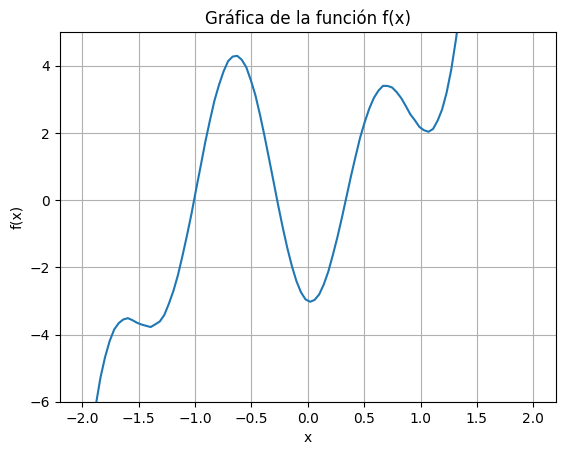

In [4]:
plt.plot(x_puntos, y_puntos)
plt.ylim(-6, 5)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Gráfica de la función f(x)')
plt.grid(True)
plt.show()

# Definición del cromosoma

Antes de definir la función fitness debemos establecer como será el cromosoma de nuestros individuos, en esto caso el individuo tendra numero de genes por cada coeficiente el cual estará definido por la siguiente variable.

In [5]:
bits_por_coeficiente = 3

Definimos una función que nos va a ayudar a decodificar el cromosoma de nuestros individuos

In [6]:
def decode_bin(bin: str):
  ind = []
  for i in range(0, len(bin), bits_por_coeficiente):
    bin_slice = bin[i : i + bits_por_coeficiente]
    coeficiente = int(bin_slice, 2)
    ind.append(coeficiente)
  return ind

In [7]:
def fitness(bin: str):
    ind = decode_bin(bin)
    a, b, c, d, e = ind
    def funcion(x):
      return a*x**3 + b*x**2 - c * x - d * math.cos(e*x)

    aprox = np.array([funcion(x) for x in x_puntos])
    error = np.sum((np.array(y_puntos) - aprox)**2) / len(x_puntos)

    return error,

# Evolución

La evolución se llevará a cabo por medio de una implementación del algoritmo genético compacto escrita por mí

In [8]:
import random


class Individual:
    def __init__(self, chrom: list[int]) -> None:
        self.chrom = chrom
        self.fitness = None

    def __str__(self) -> str:
        return '{} Fitness: {}'.format(self.chrom, self.fitness)


def initialize_probs(num_genes: int) -> list[float]:
    return [0.5 for _ in range(num_genes)]


def create_individual(probs: list[float]):
    chrom = ['1' if random.uniform(0, 1) < prob else '0' for prob in probs]
    return Individual(''.join(chrom))


def compete(a: Individual, b: Individual, fitness: callable, fitness_min: bool):
    a.fitness = fitness(a.chrom)
    b.fitness = fitness(b.chrom)

    if a.fitness < b.fitness and fitness_min:
        return a, b

    if a.fitness > b.fitness and not fitness_min:
        return a, b

    return b, a


def adjust_probs(probs: list[float], winner: Individual, loser: Individual, generations: int):
    new_probs = []

    for i in range(len(probs)):
        loser_gen = loser.chrom[i]
        winner_gen = winner.chrom[i]

        if winner_gen == loser_gen:
            new_probs.append(probs[i])
            continue

        if winner_gen == '0':
            new_probs.append(probs[i] - 1/generations)
            continue

        new_probs.append(probs[i] + 1/generations)
    return new_probs


def has_converged(probs: list[float], convergence_criteria: float):
    for prob in probs:
        diff = 1 - prob
        if diff > convergence_criteria:
            return False
    return True


def evolve(fitness: callable, num_genes: int, generations: int, convergence_criteria=0.001, fitness_min=False):
    best = None
    probs = initialize_probs(num_genes)

    for _ in range(generations):
        a = create_individual(probs)
        b = create_individual(probs)

        winner, loser = compete(a, b, fitness, fitness_min)

        if not best:
            best = winner
        elif winner.fitness > best.fitness and not fitness_min:
            best = winner
        elif winner.fitness < best.fitness and fitness_min:
            best = winner

        probs = adjust_probs(probs, winner, loser, generations)

        if has_converged(probs, convergence_criteria):
            break

    return best.chrom

# Ejecución de la evolución


In [16]:
num_coeficientes = 5
generations = 10000
num_genes = bits_por_coeficiente * num_coeficientes

best = evolve(fitness, num_genes, generations, fitness_min=True)

# Echemos un vistazo al ganador

In [17]:
best

'011010010011101'

# Decodificamos al ganador

In [18]:
ind = decode_bin(best)
ind

[3, 2, 2, 3, 5]

# Echemos un vistazo a los resultados

Vamos a gráficar con los resultados del individuo ganador

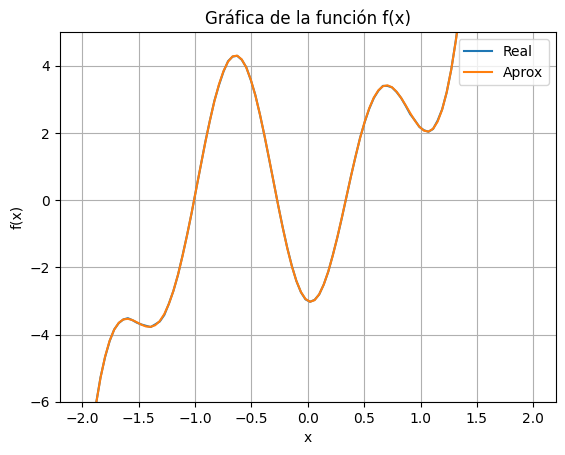

In [19]:
a, b, c, d, e = ind
def f(x):
  return a*x**3 + b*x**2 - c * x - d * math.cos(e*x)

y = [f(x) for x in x_puntos]

plt.plot(x_puntos, y_puntos, label='Real')
plt.plot(x_puntos, y, label='Aprox')
plt.ylim(-6, 5)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Gráfica de la función f(x)')
plt.legend()
plt.grid(True)
plt.show()